In [1]:
from scripts.SimulatedUser import SimulatedUser
from utils.ElasticSearch import create_elasticsearch_client, create_index, index_news_articles
from utils.sqlitedb import save_user_profile, create_db, delete_db

First, delete any current user profile database and create a new one.

In [2]:
delete_db()
create_db()

Database deleted successfully.
Database and table created successfully.


In [3]:
DATA_FILE = "data/News_Category_Dataset_v3.json"
client = create_elasticsearch_client()
index_name = "news_articles"
create_index(client, index_name)

Index 'news_articles' already exists and will be used.


/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python3-3.11.6-env/lib/python3.11/site-packages/elasticsearch/_sync/client/__init__.py:395: SecurityWarning: Connecting to 'https://localhost:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(
/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python3-3.11.6-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


## Random User Generation

In [4]:
# # Define the number of users and queries per user
num_users = 10
num_queries_per_user = 100

# Simulate users' search behavior
simulated_users = []
for i in range(num_users):
  user = SimulatedUser(user_id=i+1)
  user.simulate_search(client, index_name, num_queries_per_user)
  simulated_users.append(user)

# Print profiles
for user in simulated_users:
  # user.print_profile()
  save_user_profile(user.profile)

/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python3-3.11.6-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python3-3.11.6-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python3-3.11.6-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.read

## Targeted User Generation

In [5]:
num_queries_per_user = 500

# Define targeted user preferences
targeted_users = [
  (SimulatedUser(user_id="sportive"), ["SPORTS", "HEALTHY LIVING", "ENTERTAINMENT", "TRAVEL"]),
  (SimulatedUser(user_id="activist"), ["POLITICS", "BLACK VOICES", "QUEER VOICES"]),
  (SimulatedUser(user_id="businessman"), ["BUSINESS"])
]

# Simulate search behavior for targeted users and print profiles
for user, preferences in targeted_users:
  user.simulate_search_targeted(client, index_name, num_queries_per_user, preferences)
  # user.print_profile()
  save_user_profile(user.profile)

/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python3-3.11.6-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python3-3.11.6-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/nix/store/lgl1qcwcrfrh27825rs1hk4sx8a4m602-python3-3.11.6-env/lib/python3.11/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.read

### Word Clouds

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# First, acquiring the user profile term vector from each of the simulated users
term_preferences = [user.profile.term_preferences for user, categories in targeted_users]

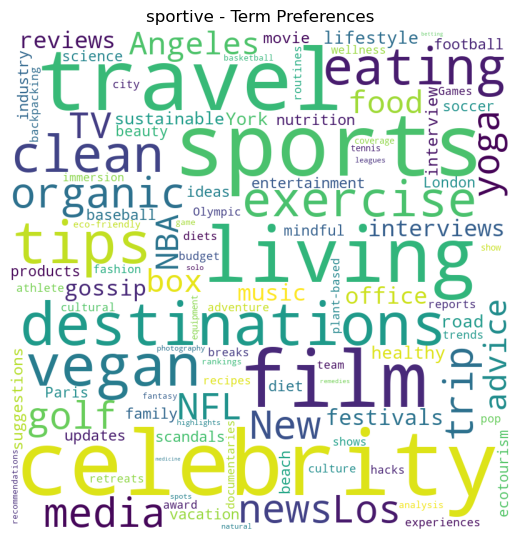

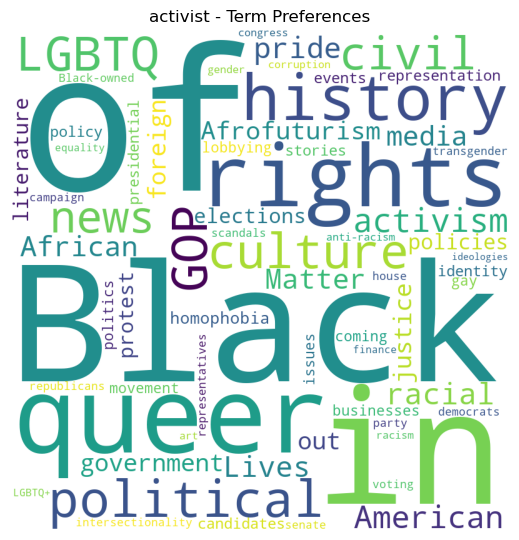

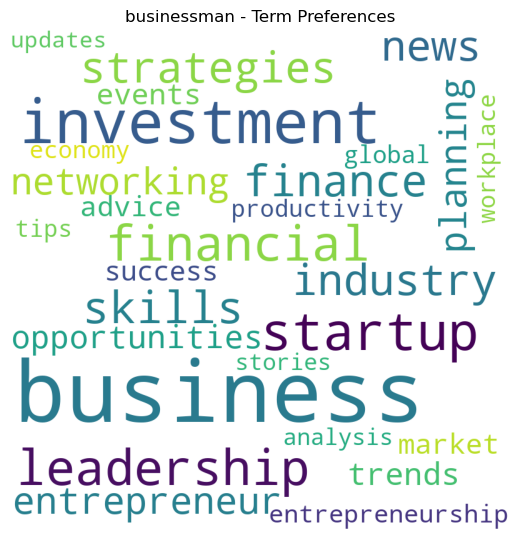

In [8]:
# For each of the user profile term vectors, we will plot a word cloud
for i, user in enumerate(targeted_users):
  wc = WordCloud(width=800, height=800, background_color='white', max_words=150, colormap='viridis').generate_from_frequencies(term_preferences[i])
  plt.figure(figsize=(8, 5), facecolor=None)
  plt.imshow(wc)
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.title(f"{user[0].user_id} - Term Preferences")
  plt.show()